### 전체 환자 사망 여부 예측

In [1]:
import pandas as pd
df = pd.read_csv('/Users/hwangjeonghyun/COVID-19-Machine-Learning/data/processed/covid_preprocessed_all_patients.csv')

In [2]:
df.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEATH,PREGNANT_CLEAN
0,1,1,65,2,2,2,2,1,2,2,2,2,2,3,1,No
1,2,1,72,2,2,2,2,1,2,2,1,1,2,5,1,NotApplicable
2,2,2,55,1,2,2,2,2,2,2,2,2,2,3,1,NotApplicable
3,1,2,53,2,2,2,2,2,2,2,2,2,2,7,1,No
4,2,2,68,1,2,2,2,1,2,2,2,2,2,3,1,NotApplicable


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 범주형/수치형 컬럼 정의
categorical_cols = [
    "CLASIFFICATION_FINAL",            # 전체 환자 분석에서는 포함(원핫)
    "SEX","PREGNANT_CLEAN","PNEUMONIA","DIABETES","COPD","ASTHMA","INMSUPR",
    "HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY",
    "RENAL_CHRONIC","TOBACCO"
]

# X/y 분리
y = df["DEATH"]
X = df.drop(columns=["DEATH"])

# 원-핫 인코딩 (drop_first=False: 모든 범주 보존)
X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

print("최종 Feature shape:", X.shape)
print("Feature 예시:", X.columns[:50].tolist())

최종 Feature shape: (1048575, 47)
Feature 예시: ['AGE', 'CLASIFFICATION_FINAL_1', 'CLASIFFICATION_FINAL_2', 'CLASIFFICATION_FINAL_3', 'CLASIFFICATION_FINAL_4', 'CLASIFFICATION_FINAL_5', 'CLASIFFICATION_FINAL_6', 'CLASIFFICATION_FINAL_7', 'SEX_1', 'SEX_2', 'PREGNANT_CLEAN_No', 'PREGNANT_CLEAN_NotApplicable', 'PREGNANT_CLEAN_Unknown', 'PREGNANT_CLEAN_Yes', 'PNEUMONIA_1', 'PNEUMONIA_2', 'PNEUMONIA_99', 'DIABETES_1', 'DIABETES_2', 'DIABETES_Unknown', 'COPD_1', 'COPD_2', 'COPD_Unknown', 'ASTHMA_1', 'ASTHMA_2', 'ASTHMA_Unknown', 'INMSUPR_1', 'INMSUPR_2', 'INMSUPR_Unknown', 'HIPERTENSION_1', 'HIPERTENSION_2', 'HIPERTENSION_Unknown', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'OTHER_DISEASE_Unknown', 'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'CARDIOVASCULAR_Unknown', 'OBESITY_1', 'OBESITY_2', 'OBESITY_Unknown', 'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'RENAL_CHRONIC_Unknown', 'TOBACCO_1', 'TOBACCO_2', 'TOBACCO_Unknown']


In [4]:
# 라이브러리, 기본 설정
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, average_precision_score)
from sklearn.utils import shuffle
from joblib import dump, load
import lightgbm as lgb
import json, os

# 설정
GLOBAL_RS = 42
N_RUNS = 10   # 반복 횟수
ARTIFACT_DIR = "./modeling_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [5]:
# 데이터 6:2:2 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=GLOBAL_RS, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=GLOBAL_RS, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("사망 비율 — train:{:.4f}  val:{:.4f}  test:{:.4f}".format(
    np.mean(y_train), np.mean(y_val), np.mean(y_test)))


Train: (629145, 47) Val: (209715, 47) Test: (209715, 47)
사망 비율 — train:0.0734  val:0.0734  test:0.0734


In [6]:
scaler = StandardScaler()
if "AGE" in X_train.columns:
    scaler.fit(X_train[["AGE"]])
    X_train.loc[:, "AGE"] = scaler.transform(X_train[["AGE"]]).astype(float)
    X_val.loc[:,   "AGE"] = scaler.transform(X_val[["AGE"]]).astype(float)
    X_test.loc[:,  "AGE"] = scaler.transform(X_test[["AGE"]]).astype(float)

/var/folders/zx/cn5rp85x1gg2mjyqzz1tnj480000gn/T/ipykernel_974/3884454815.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.93489021  0.12990786 -0.63911297 ... -0.40249117 -1.64475559
  1.07639504]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, "AGE"] = scaler.transform(X_train[["AGE"]]).astype(float)
/var/folders/zx/cn5rp85x1gg2mjyqzz1tnj480000gn/T/ipykernel_974/3884454815.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.24821876 -1.05320111  0.42568511 ... -0.10671393  0.543996
 -0.40249117]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_val.loc[:,   "AGE"] = scaler.transform(X_val[["AGE"]]).astype(float)
/var/folders/zx/cn5rp85x1gg2mjyqzz1tnj480000gn/T/ipykernel_974/3884454815.py:6: FutureWarning: Setting an item of incompatib

In [7]:
# 하이퍼파라미터 탐색 (LightGBM, 최소 필수만 + 조기종료)
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

base = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_jobs=-1,
    random_state=GLOBAL_RS,
    # 고정값: 조기종료와 함께 사용
    learning_rate=0.05,
    max_depth=-1,
    n_estimators=2000,   
    verbosity=-1
)

param_grid = {
    "num_leaves": [31, 63],
    "min_child_samples": [20, 100],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [0.0, 1.0],   # L2 정규화 강도
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_RS)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# 조기 종료를 위해 검증 세트를 eval_set으로 고정 전달
grid.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

best_params_fixed = grid.best_params_
best_cv_auc = grid.best_score_
print("Best params (fixed):", best_params_fixed)
print("CV AUC (Train CV):", best_cv_auc)


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[206]	valid_0's auc: 0.93339	valid_0's binary_logloss: 0.148588
Early stopping, best iteration is:
[206]	valid_0's auc: 0.93339	valid_0's binary_logloss: 0.148588
Early stopping, best iteration is:
[214]	valid_0's auc: 0.933498	valid_0's binary_logloss: 0.14851
Early stopping, best iteration is:
[214]	valid_0's auc: 0.933498	valid_0's binary_logloss: 0.14851
Early stopping, best iteration is:
[220]	valid_0's auc: 0.933291	valid_0's binary_logloss: 0.148646
Early st

In [8]:
# 고정된 HP로 10회 학습(시드만 변경) → Val에서 베스트 선택 + 체크포인트 저장 (LightGBM)
run_records = []
best_val_auc = -np.inf
best_run_idx = -1
best_model = None
best_iter_for_ckpt = None

for rseed in range(N_RUNS):
    print(f"\n=== Fixed-HP Run {rseed+1}/{N_RUNS} ===")

    # 시드별로 Train만 섞어 학습
    X_tr, y_tr = shuffle(X_train, y_train, random_state=rseed)

    # LightGBM 모델 (그리드서치에서 얻은 best_params_fixed 사용)
    model = lgb.LGBMClassifier(
        **best_params_fixed,
        objective="binary",
        n_jobs=-1,
        class_weight="balanced",
        random_state=rseed,      # 시드만 변경
        verbosity=-1
    )

    # 조기 종료로 최적 반복 결정 (Val 사용)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    # 최적 반복에서 예측
    best_iter = model.best_iteration_
    val_prob = model.predict_proba(X_val, num_iteration=best_iter)[:, 1]
    val_auc  = roc_auc_score(y_val, val_prob)
    val_pred05 = (val_prob >= 0.5).astype(int)

    rec = {
        "run": rseed,
        "val_auc": float(val_auc),
        "val_acc@0.5": float(accuracy_score(y_val, val_pred05)),
        "val_f1@0.5": float(f1_score(y_val, val_pred05)),
        "val_recall@0.5": float(recall_score(y_val, val_pred05)),
        "val_precision@0.5": float(precision_score(y_val, val_pred05)),
        "best_iteration": int(best_iter) if best_iter is not None else None
    }
    run_records.append(rec)
    print(f"VAL AUC: {val_auc:.4f} (best_iter={best_iter})")

    # 베스트 갱신 시 즉시 저장(체크포인트)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model
        best_run_idx = rseed
        best_iter_for_ckpt = best_iter

        # joblib로 모델 저장
        dump(best_model, f"{ARTIFACT_DIR}/best_checkpoint_lgbm.joblib")

        # LightGBM 텍스트 모델도 함께 저장
        try:
            best_model.booster_.save_model(f"{ARTIFACT_DIR}/best_checkpoint_lgbm.txt")
        except Exception:
            pass

        # 메타 저장
        with open(f"{ARTIFACT_DIR}/checkpoint_meta_lgbm.json", "w") as f:
            json.dump({
                "selected_run": int(best_run_idx),
                "best_val_auc": float(best_val_auc),
                "fixed_best_params": best_params_fixed,
                "best_iteration": int(best_iter_for_ckpt) if best_iter_for_ckpt is not None else None
            }, f, ensure_ascii=False, indent=2)

        print(f"[Checkpoint saved] Run {best_run_idx}, VAL AUC={best_val_auc:.4f}, best_iter={best_iter_for_ckpt}")

top3 = sorted(run_records, key=lambda x: x["val_auc"], reverse=True)[:3]
print("\nTop runs by VAL AUC:\n", top3)



=== Fixed-HP Run 1/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.933569	valid_0's binary_logloss: 0.338527
VAL AUC: 0.9336 (best_iter=99)
[Checkpoint saved] Run 0, VAL AUC=0.9336, best_iter=99

=== Fixed-HP Run 2/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.93366	valid_0's binary_logloss: 0.338423
VAL AUC: 0.9337 (best_iter=98)
[Checkpoint saved] Run 1, VAL AUC=0.9337, best_iter=98

=== Fixed-HP Run 3/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.933683	valid_0's binary_logloss: 0.338577
VAL AUC: 0.9337 (best_iter=89)
[Checkpoint saved] Run 2, VAL AUC=0.9337, best_iter=89

=== Fixed-HP Run 4/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84

In [9]:
# 임계값 최적화 (F1 기준, Val만 사용) — LightGBM 버전
def find_best_threshold_by_f1(y_true, y_prob, grid=np.linspace(0.05, 0.95, 37)):
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# LightGBM은 조기 종료를 쓴 경우 최적 반복(best_iteration_)에서 예측하는 것이 중요
_best_iter = getattr(best_model, "best_iteration_", None)  # 없으면 None 반환
if _best_iter is not None and _best_iter > 0:
    val_prob_best = best_model.predict_proba(X_val, num_iteration=_best_iter)[:, 1]
else:
    val_prob_best = best_model.predict_proba(X_val)[:, 1]

best_thresh, best_val_f1 = find_best_threshold_by_f1(y_val, val_prob_best)
val_pr_auc = average_precision_score(y_val, val_prob_best)

print(f"Best threshold(F1): {best_thresh:.2f} | VAL F1: {best_val_f1:.4f} | VAL PR-AUC: {val_pr_auc:.4f}")


Best threshold(F1): 0.82 | VAL F1: 0.5609 | VAL PR-AUC: 0.5599


In [10]:
# Train+Val 재학습 → 최종 모델 확정

# best_iteration 가져오기 (조기 종료를 쓴 경우)
_best_iter = getattr(best_model, "best_iteration_", None)

# 없으면 기본값(n_estimators) 사용
n_estimators_final = int(_best_iter) if _best_iter and _best_iter > 0 else best_params_fixed.get("n_estimators", 200)

# 최종 학습 파라미터 확정
final_params = {**best_params_fixed, "n_estimators": n_estimators_final}

# 최종 모델 정의
final_model = lgb.LGBMClassifier(
    **final_params,
    objective="binary",
    n_jobs=-1,
    class_weight="balanced",
    random_state=0,   # 재현성용
    verbosity=-1
)

# Train+Val 전체 데이터로 학습
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    eval_metric="auc"
)

print(f"Final LightGBM model trained on Train+Val with n_estimators={n_estimators_final}.")

Final LightGBM model trained on Train+Val with n_estimators=89.


In [11]:
# Test 1회 평가 (0.5 & 최적 임계값 비교) - LightGBM 버전
def evaluate_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"ACC: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {prec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

# LightGBM은 best_iteration_ 고려해서 확률 예측
_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter is not None and _best_iter > 0:
    test_prob = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    test_prob = final_model.predict_proba(X_test)[:, 1]

# 평가 (0.5 임계값 & 최적 임계값)
evaluate_binary(y_test, test_prob, threshold=0.5, title="Test @0.5")
evaluate_binary(y_test, test_prob, threshold=best_thresh, title="Test @optimal threshold (F1 from VAL)")



=== Test @0.5 ===
Threshold: 0.50
ROC-AUC: 0.9332 | PR-AUC: 0.5610
ACC: 0.8469 | F1: 0.4583 | Recall: 0.8824 | Precision: 0.3095
Confusion matrix [[TN FP],[FN TP]]:
 [[164039  30288]
 [  1810  13578]]
              precision    recall  f1-score   support

           0     0.9891    0.8441    0.9109    194327
           1     0.3095    0.8824    0.4583     15388

    accuracy                         0.8469    209715
   macro avg     0.6493    0.8633    0.6846    209715
weighted avg     0.9392    0.8469    0.8777    209715


=== Test @optimal threshold (F1 from VAL) ===
Threshold: 0.82
ROC-AUC: 0.9332 | PR-AUC: 0.5610
ACC: 0.9243 | F1: 0.5598 | Recall: 0.6560 | Precision: 0.4882
Confusion matrix [[TN FP],[FN TP]]:
 [[183743  10584]
 [  5293  10095]]
              precision    recall  f1-score   support

           0     0.9720    0.9455    0.9586    194327
           1     0.4882    0.6560    0.5598     15388

    accuracy                         0.9243    209715
   macro avg     0.7301

In [12]:
# 최종 저장 + 재로딩 검증

# 모델 저장 (joblib)
dump(final_model, f"{ARTIFACT_DIR}/best_lgbm_FINAL.joblib")

# 메타데이터 저장
with open(f"{ARTIFACT_DIR}/metadata_lgbm.json", "w") as f:
    json.dump({
        "selected_run": int(best_run_idx),
        "best_val_auc": float(best_val_auc),
        "best_threshold(F1)": float(best_thresh),
        "fixed_best_params": best_params_fixed,
        "n_runs": int(N_RUNS),
        "run_records_top3": top3,
        "best_iteration": int(getattr(final_model, "best_iteration_", 0))  # 없으면 0
    }, f, ensure_ascii=False, indent=2)

# 재로딩 검증
loaded = load(f"{ARTIFACT_DIR}/best_lgbm_FINAL.joblib")

_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter and _best_iter > 0:
    p1 = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
    p2 = loaded.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    p1 = final_model.predict_proba(X_test)[:, 1]
    p2 = loaded.predict_proba(X_test)[:, 1]

assert np.allclose(p1, p2), "Reloaded predictions differ!"
print("Reloaded predictions are identical")


Reloaded predictions are identical


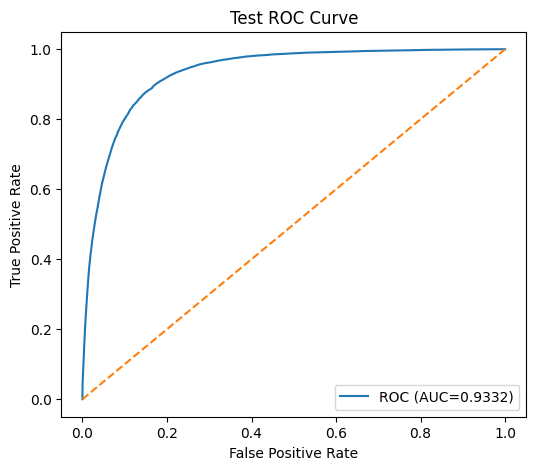

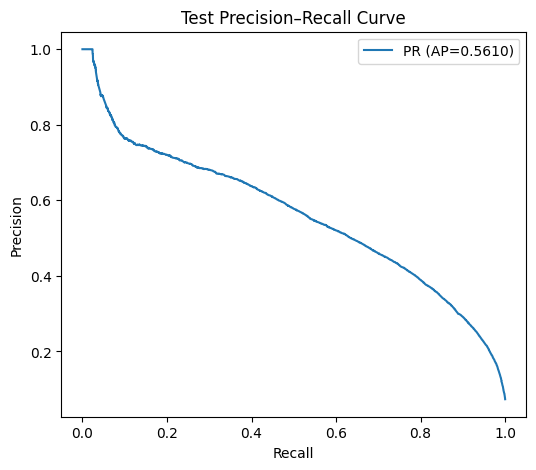

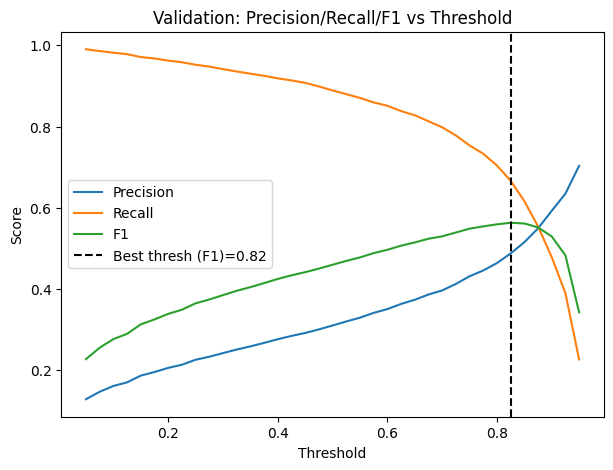

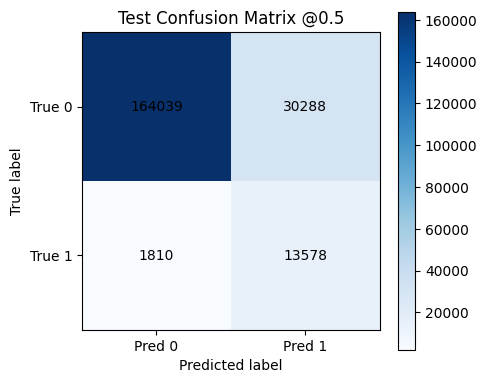

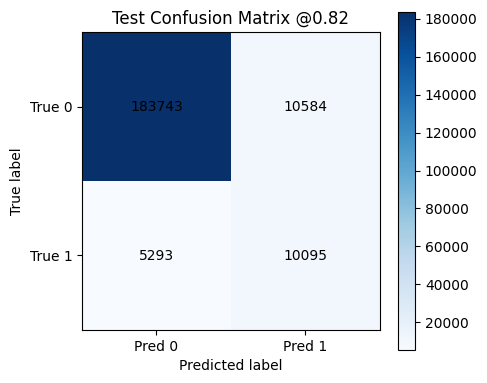

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
)
import numpy as np

# ============================
# 확률 추출 (LightGBM: best_iteration_ 반영)
# ============================
_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter is not None and _best_iter > 0:
    val_prob_best = final_model.predict_proba(X_val,  num_iteration=_best_iter)[:, 1]
    test_prob     = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    val_prob_best = final_model.predict_proba(X_val)[:, 1]
    test_prob     = final_model.predict_proba(X_test)[:, 1]

# ---------------------------
# 1) ROC Curve (Test)
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 2) Precision–Recall Curve (Test)
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, test_prob)
pr_auc = average_precision_score(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------------------
# 3) Threshold vs Precision/Recall/F1 (Validation 기준)
# ---------------------------
def curve_threshold_metrics(y_true, y_prob, grid=np.linspace(0.05,0.95,37)):
    precs, recs, f1s = [], [], []
    for t in grid:
        y_pred = (y_prob >= t).astype(int)
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    return grid, precs, recs, f1s

ts, precs, recs, f1s = curve_threshold_metrics(y_val, val_prob_best)

plt.figure(figsize=(7,5))
plt.plot(ts, precs, label="Precision")
plt.plot(ts, recs,  label="Recall")
plt.plot(ts, f1s,   label="F1")
plt.axvline(best_thresh, linestyle="--", color="k", label=f"Best thresh (F1)={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Validation: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.show()

# ---------------------------
# 4) Confusion Matrix (Test @0.5 vs @best_thresh)
# ---------------------------
def plot_cm(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center", color="black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

plot_cm(y_test, test_prob, 0.5, "Test Confusion Matrix @0.5")
plot_cm(y_test, test_prob, best_thresh, f"Test Confusion Matrix @{best_thresh:.2f}")


### Resampling
- 언더샘플링 (Undersampling)

    - 다수 클래스(생존자) 데이터를 줄여서, 소수 클래스(사망자)와 비율을 맞춤


- 오버샘플링 (Oversampling)

    - 소수 클래스(사망자) 데이터를 복제하거나 합성해서 늘려줌


In [15]:
# === Resampling at fixed threshold = 0.5 (LightGBM with best_params) ===
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix, accuracy_score
)
import lightgbm as lgb

# 1) y를 0/1로 (1=사망, 0=생존)
y_train_bin = (y_train == 1).astype(int)
y_val_bin   = (y_val   == 1).astype(int)
y_test_bin  = (y_test  == 1).astype(int)

# 2) 트리 모델은 스케일링 불필요 → 그대로 통과
preproc = ColumnTransformer(transformers=[], remainder="passthrough")

# 3) 튜닝된 best_params 반영
best_params = {
    "colsample_bytree": 0.8,
    "min_child_samples": 100,
    "num_leaves": 31,
    "reg_lambda": 0.0,
    "subsample": 0.8,
}

# 4) 기본 학습 세팅(객체 목적/메트릭/러닝레이트 등) + best_params 병합
base_lgbm_kwargs = dict(
    objective="binary",
    metric="auc",
    n_estimators=2000,       # early stopping으로 실제 best_iter에서 멈춤
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    is_unbalance=False       # 리샘플링을 쓰므로 불균형 옵션은 끔
)
base_lgbm_kwargs.update(best_params)

def make_pipe_lgbm(sampler=None, random_state=42):
    clf = lgb.LGBMClassifier(**{**base_lgbm_kwargs, "random_state": random_state})
    steps = [("prep", preproc)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", clf))
    return ImbPipeline(steps=steps)

pipelines = {
    "UnderSampler(RUS)+LGBM": make_pipe_lgbm(RandomUnderSampler(random_state=42)),
    "OverSampler(ROS)+LGBM":  make_pipe_lgbm(RandomOverSampler(random_state=42)),
}

def evaluate_fixed_thr(y_true, prob, thr=0.5):
    pred = (prob >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, pred)
    roc = roc_auc_score(y_true, prob)
    prc = average_precision_score(y_true, prob)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {"ACC":acc, "F1":f1, "Precision":p, "Recall":r, "ROC-AUC":roc, "PR-AUC":prc,
            "TN":tn, "FP":fp, "FN":fn, "TP":tp}

rows = []
for name, pipe in pipelines.items():
    print(f"\n=== {name} @thr=0.50 ===")
    # 파이프라인의 최종 스텝(clf)에 fit 파라미터 전달: early stopping, eval set
    pipe.fit(
        X_train, y_train_bin,
        clf__eval_set=[(X_val, y_val_bin)],
        clf__eval_metric=["auc", "binary_logloss"],
        clf__callbacks=[
        lgb.early_stopping(100),     # ← 조기종료(개선 없으면 100라운드 후 stop)
        lgb.log_evaluation(50)       # ← 50라운드마다 로그(원하면 False로 없앨 수 있음)
        ]
    )

    # best_iteration_이 내부적으로 반영된 상태로 예측됨
    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    val_res  = evaluate_fixed_thr(y_val_bin,  val_prob,  thr=0.5)
    test_res = evaluate_fixed_thr(y_test_bin, test_prob, thr=0.5)

    print(f"VAL  — F1:{val_res['F1']:.4f}  Rec:{val_res['Recall']:.4f}  "
          f"Prec:{val_res['Precision']:.4f}  AUC:{val_res['ROC-AUC']:.4f}  PR-AUC:{val_res['PR-AUC']:.4f}")
    print(f"TEST — F1:{test_res['F1']:.4f}  Rec:{test_res['Recall']:.4f}  "
          f"Prec:{test_res['Precision']:.4f}  AUC:{test_res['ROC-AUC']:.4f}  PR-AUC:{test_res['PR-AUC']:.4f}")
    print("TEST CM [[TN FP],[FN TP]]:", test_res["TN"], test_res["FP"], test_res["FN"], test_res["TP"])

    rows.append({"Model":name, **{k:(round(v,4) if isinstance(v,float) else v) for k,v in test_res.items()}})

result_05 = pd.DataFrame(rows).sort_values(by="F1", ascending=False)
print("\n=== Resampling (thr=0.50) — TEST summary (LGBM with best_params) ===")
print(result_05.to_string(index=False))



=== UnderSampler(RUS)+LGBM @thr=0.50 ===
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.355981	valid_0's auc: 0.931246
[100]	valid_0's binary_logloss: 0.343432	valid_0's auc: 0.932892
[150]	valid_0's binary_logloss: 0.342038	valid_0's auc: 0.933252
[200]	valid_0's binary_logloss: 0.342041	valid_0's auc: 0.933272
[250]	valid_0's binary_logloss: 0.342175	valid_0's auc: 0.93327
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.341983	valid_0's auc: 0.933278
VAL  — F1:0.4584  Rec:0.8870  Prec:0.3091  AUC:0.9333  PR-AUC:0.5575
TEST — F1:0.4578  Rec:0.8826  Prec:0.3090  AUC:0.9327  PR-AUC:0.5563
TEST CM [[TN FP],[FN TP]]: 163960 30367 1807 13581

=== OverSampler(ROS)+LGBM @thr=0.50 ===
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.35442	valid_0's auc: 0.931466
[100]	valid_0's binary_logloss: 0.341374	valid_0's auc: 0.933083
[150]	valid_0's binary_logloss: 0.339219	valid_0's au

### 코로나 양성 환자(확진자) 사망 여부 예측

In [16]:
import pandas as pd
df = pd.read_csv('/Users/hwangjeonghyun/COVID-19-Machine-Learning/data/processed/covid_preprocessed_positive_patients.csv')

In [17]:
df.head()

,SEX,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,DEATH,PREGNANT_CLEAN
0,1,1,65,2,2,2,2,1,2,2,2,2,2,3,1,No
1,2,2,55,1,2,2,2,2,2,2,2,2,2,3,1,NotApplicable
2,2,2,68,1,2,2,2,1,2,2,2,2,2,3,1,NotApplicable
3,1,1,40,2,2,2,2,2,2,2,2,2,2,3,0,No
4,1,2,64,2,2,2,2,2,2,2,2,2,2,3,0,No


In [18]:
# 범주형/수치형 컬럼 정의 (확진자만이므로 CLASIFFICATION_FINAL 제외)
categorical_cols = [
    "SEX","PREGNANT_CLEAN","PNEUMONIA","DIABETES","COPD","ASTHMA","INMSUPR",
    "HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY",
    "RENAL_CHRONIC","TOBACCO"
]
numeric_cols = ["AGE"]  

# X/y 분리
y = df["DEATH"]
X = df.drop(columns=["DEATH", "CLASIFFICATION_FINAL"], errors="ignore")

# 원-핫 인코딩
X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

print("최종 Feature shape:", X.shape)
print("Feature 예시:", X.columns[:50].tolist())

최종 Feature shape: (391979, 40)
Feature 예시: ['AGE', 'SEX_1', 'SEX_2', 'PREGNANT_CLEAN_No', 'PREGNANT_CLEAN_NotApplicable', 'PREGNANT_CLEAN_Unknown', 'PREGNANT_CLEAN_Yes', 'PNEUMONIA_1', 'PNEUMONIA_2', 'PNEUMONIA_99', 'DIABETES_1', 'DIABETES_2', 'DIABETES_Unknown', 'COPD_1', 'COPD_2', 'COPD_Unknown', 'ASTHMA_1', 'ASTHMA_2', 'ASTHMA_Unknown', 'INMSUPR_1', 'INMSUPR_2', 'INMSUPR_Unknown', 'HIPERTENSION_1', 'HIPERTENSION_2', 'HIPERTENSION_Unknown', 'OTHER_DISEASE_1', 'OTHER_DISEASE_2', 'OTHER_DISEASE_Unknown', 'CARDIOVASCULAR_1', 'CARDIOVASCULAR_2', 'CARDIOVASCULAR_Unknown', 'OBESITY_1', 'OBESITY_2', 'OBESITY_Unknown', 'RENAL_CHRONIC_1', 'RENAL_CHRONIC_2', 'RENAL_CHRONIC_Unknown', 'TOBACCO_1', 'TOBACCO_2', 'TOBACCO_Unknown']


In [19]:
# 라이브러리, 기본 설정
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix, average_precision_score)
from sklearn.utils import shuffle
from joblib import dump, load
import lightgbm as lgb
import json, os

# 설정
GLOBAL_RS = 42
N_RUNS = 10   # 반복 횟수
ARTIFACT_DIR = "./modeling_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [20]:
# 데이터 6:2:2 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=GLOBAL_RS, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=GLOBAL_RS, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("사망 비율 — train:{:.4f}  val:{:.4f}  test:{:.4f}".format(
    np.mean(y_train), np.mean(y_val), np.mean(y_test)))

Train: (235187, 40) Val: (78396, 40) Test: (78396, 40)
사망 비율 — train:0.1384  val:0.1384  test:0.1384


In [21]:
scaler = StandardScaler()
if "AGE" in X_train.columns:
    scaler.fit(X_train[["AGE"]])
    X_train.loc[:, "AGE"] = scaler.transform(X_train[["AGE"]]).astype(float)
    X_val.loc[:,   "AGE"] = scaler.transform(X_val[["AGE"]]).astype(float)
    X_test.loc[:,  "AGE"] = scaler.transform(X_test[["AGE"]]).astype(float)

In [22]:
# 하이퍼파라미터 탐색 (LightGBM, 최소 필수만 + 조기종료)
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

base = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    n_jobs=-1,
    random_state=GLOBAL_RS,
    # 고정값: 조기종료와 함께 사용
    learning_rate=0.05,
    max_depth=-1,
    n_estimators=2000,   
    verbosity=-1
)

param_grid = {
    "num_leaves": [31, 63],
    "min_child_samples": [20, 100],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "reg_lambda": [0.0, 1.0],   # L2 정규화 강도
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_RS)
grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True
)

# 조기 종료를 위해 검증 세트를 eval_set으로 고정 전달
grid.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

best_params_fixed = grid.best_params_
best_cv_auc = grid.best_score_
print("Best params (fixed):", best_params_fixed)
print("CV AUC (Train CV):", best_cv_auc)


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's auc: 0.908501	valid_0's binary_logloss: 0.2459
Early stopping, best iteration is:
[135]	valid_0's auc: 0.908736	valid_0's binary_logloss: 0.245566
Early stopping, best iteration is:
[133]	valid_0's auc: 0.908501	valid_0's binary_logloss: 0.2459
Early stopping, best iteration is:
[128]	valid_0's auc: 0.908801	valid_0's binary_logloss: 0.245544
Early stopping, best iteration is:
[142]	valid_0's auc: 0.908706	valid_0's binary_logloss: 0.245655
Training

In [23]:
# 고정된 HP로 10회 학습(시드만 변경) → Val에서 베스트 선택 + 체크포인트 저장 (LightGBM)
run_records = []
best_val_auc = -np.inf
best_run_idx = -1
best_model = None
best_iter_for_ckpt = None

for rseed in range(N_RUNS):
    print(f"\n=== Fixed-HP Run {rseed+1}/{N_RUNS} ===")

    # 시드별로 Train만 섞어 학습
    X_tr, y_tr = shuffle(X_train, y_train, random_state=rseed)

    # LightGBM 모델 (그리드서치에서 얻은 best_params_fixed 사용)
    model = lgb.LGBMClassifier(
        **best_params_fixed,
        objective="binary",
        n_jobs=-1,
        class_weight="balanced",
        random_state=rseed,      # 시드만 변경
        verbosity=-1
    )

    # 조기 종료로 최적 반복 결정 (Val 사용)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
    )

    # 최적 반복에서 예측
    best_iter = model.best_iteration_
    val_prob = model.predict_proba(X_val, num_iteration=best_iter)[:, 1]
    val_auc  = roc_auc_score(y_val, val_prob)
    val_pred05 = (val_prob >= 0.5).astype(int)

    rec = {
        "run": rseed,
        "val_auc": float(val_auc),
        "val_acc@0.5": float(accuracy_score(y_val, val_pred05)),
        "val_f1@0.5": float(f1_score(y_val, val_pred05)),
        "val_recall@0.5": float(recall_score(y_val, val_pred05)),
        "val_precision@0.5": float(precision_score(y_val, val_pred05)),
        "best_iteration": int(best_iter) if best_iter is not None else None
    }
    run_records.append(rec)
    print(f"VAL AUC: {val_auc:.4f} (best_iter={best_iter})")

    # 베스트 갱신 시 즉시 저장(체크포인트)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model
        best_run_idx = rseed
        best_iter_for_ckpt = best_iter

        # joblib로 모델 저장
        dump(best_model, f"{ARTIFACT_DIR}/best_checkpoint_lgbm.joblib")

        # LightGBM 텍스트 모델도 함께 저장
        try:
            best_model.booster_.save_model(f"{ARTIFACT_DIR}/best_checkpoint_lgbm.txt")
        except Exception:
            pass

        # 메타 저장
        with open(f"{ARTIFACT_DIR}/checkpoint_meta_lgbm.json", "w") as f:
            json.dump({
                "selected_run": int(best_run_idx),
                "best_val_auc": float(best_val_auc),
                "fixed_best_params": best_params_fixed,
                "best_iteration": int(best_iter_for_ckpt) if best_iter_for_ckpt is not None else None
            }, f, ensure_ascii=False, indent=2)

        print(f"[Checkpoint saved] Run {best_run_idx}, VAL AUC={best_val_auc:.4f}, best_iter={best_iter_for_ckpt}")

top3 = sorted(run_records, key=lambda x: x["val_auc"], reverse=True)[:3]
print("\nTop runs by VAL AUC:\n", top3)



=== Fixed-HP Run 1/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.908915	valid_0's binary_logloss: 0.390054
VAL AUC: 0.9089 (best_iter=70)
[Checkpoint saved] Run 0, VAL AUC=0.9089, best_iter=70

=== Fixed-HP Run 2/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.908787	valid_0's binary_logloss: 0.390098
VAL AUC: 0.9088 (best_iter=78)

=== Fixed-HP Run 3/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.90889	valid_0's binary_logloss: 0.38997
VAL AUC: 0.9089 (best_iter=78)

=== Fixed-HP Run 4/10 ===
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.908936	valid_0's binary_logloss: 0.390044
VAL AUC: 0.9089 (best_iter=74)
[Checkpoint saved] 

In [24]:
# 임계값 최적화 (F1 기준, Val만 사용) — LightGBM 버전
def find_best_threshold_by_f1(y_true, y_prob, grid=np.linspace(0.05, 0.95, 37)):
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, pred)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

# LightGBM은 조기 종료를 쓴 경우 최적 반복(best_iteration_)에서 예측하는 것이 중요
_best_iter = getattr(best_model, "best_iteration_", None)  # 없으면 None 반환
if _best_iter is not None and _best_iter > 0:
    val_prob_best = best_model.predict_proba(X_val, num_iteration=_best_iter)[:, 1]
else:
    val_prob_best = best_model.predict_proba(X_val)[:, 1]

best_thresh, best_val_f1 = find_best_threshold_by_f1(y_val, val_prob_best)
val_pr_auc = average_precision_score(y_val, val_prob_best)

print(f"Best threshold(F1): {best_thresh:.2f} | VAL F1: {best_val_f1:.4f} | VAL PR-AUC: {val_pr_auc:.4f}")


Best threshold(F1): 0.70 | VAL F1: 0.6098 | VAL PR-AUC: 0.5848


In [25]:
# Train+Val 재학습 → 최종 모델 확정

# best_iteration 가져오기 (조기 종료를 쓴 경우)
_best_iter = getattr(best_model, "best_iteration_", None)

# 없으면 기본값(n_estimators) 사용
n_estimators_final = int(_best_iter) if _best_iter and _best_iter > 0 else best_params_fixed.get("n_estimators", 200)

# 최종 학습 파라미터 확정
final_params = {**best_params_fixed, "n_estimators": n_estimators_final}

# 최종 모델 정의
final_model = lgb.LGBMClassifier(
    **final_params,
    objective="binary",
    n_jobs=-1,
    class_weight="balanced",
    random_state=0,   # 재현성용
    verbosity=-1
)

# Train+Val 전체 데이터로 학습
final_model.fit(
    np.vstack([X_train, X_val]),
    np.hstack([y_train, y_val]),
    eval_metric="auc"
)

print(f"Final LightGBM model trained on Train+Val with n_estimators={n_estimators_final}.")

Final LightGBM model trained on Train+Val with n_estimators=74.


In [26]:
# Test 1회 평가 (0.5 & 최적 임계값 비교) - LightGBM 버전
def evaluate_binary(y_true, y_prob, threshold=0.5, title=""):
    y_pred = (y_prob >= threshold).astype(int)
    auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Threshold: {threshold:.2f}")
    print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print(f"ACC: {acc:.4f} | F1: {f1:.4f} | Recall: {rec:.4f} | Precision: {prec:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

# LightGBM은 best_iteration_ 고려해서 확률 예측
_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter is not None and _best_iter > 0:
    test_prob = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    test_prob = final_model.predict_proba(X_test)[:, 1]

# 평가 (0.5 임계값 & 최적 임계값)
evaluate_binary(y_test, test_prob, threshold=0.5, title="Test @0.5")
evaluate_binary(y_test, test_prob, threshold=best_thresh, title="Test @optimal threshold (F1 from VAL)")



=== Test @0.5 ===
Threshold: 0.50
ROC-AUC: 0.9120 | PR-AUC: 0.5944
ACC: 0.8214 | F1: 0.5754 | Recall: 0.8748 | Precision: 0.4287
Confusion matrix [[TN FP],[FN TP]]:
 [[54902 12647]
 [ 1358  9489]]
              precision    recall  f1-score   support

           0     0.9759    0.8128    0.8869     67549
           1     0.4287    0.8748    0.5754     10847

    accuracy                         0.8214     78396
   macro avg     0.7023    0.8438    0.7311     78396
weighted avg     0.9002    0.8214    0.8438     78396


=== Test @optimal threshold (F1 from VAL) ===
Threshold: 0.70
ROC-AUC: 0.9120 | PR-AUC: 0.5944
ACC: 0.8691 | F1: 0.6141 | Recall: 0.7529 | Precision: 0.5185
Confusion matrix [[TN FP],[FN TP]]:
 [[59964  7585]
 [ 2680  8167]]
              precision    recall  f1-score   support

           0     0.9572    0.8877    0.9212     67549
           1     0.5185    0.7529    0.6141     10847

    accuracy                         0.8691     78396
   macro avg     0.7378    0.82

In [27]:
# 최종 저장 + 재로딩 검증

# 모델 저장 (joblib)
dump(final_model, f"{ARTIFACT_DIR}/best_lgbm_FINAL_positive.joblib")

# 메타데이터 저장
with open(f"{ARTIFACT_DIR}/metadata_lgbm_positive.json", "w") as f:
    json.dump({
        "selected_run": int(best_run_idx),
        "best_val_auc": float(best_val_auc),
        "best_threshold(F1)": float(best_thresh),
        "fixed_best_params": best_params_fixed,
        "n_runs": int(N_RUNS),
        "run_records_top3": top3,
        "best_iteration": int(getattr(final_model, "best_iteration_", 0))  # 없으면 0
    }, f, ensure_ascii=False, indent=2)

# 재로딩 검증
loaded = load(f"{ARTIFACT_DIR}/best_lgbm_FINAL_positive.joblib")

_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter and _best_iter > 0:
    p1 = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
    p2 = loaded.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    p1 = final_model.predict_proba(X_test)[:, 1]
    p2 = loaded.predict_proba(X_test)[:, 1]

assert np.allclose(p1, p2), "Reloaded predictions differ!"
print("Reloaded predictions are identical")


Reloaded predictions are identical


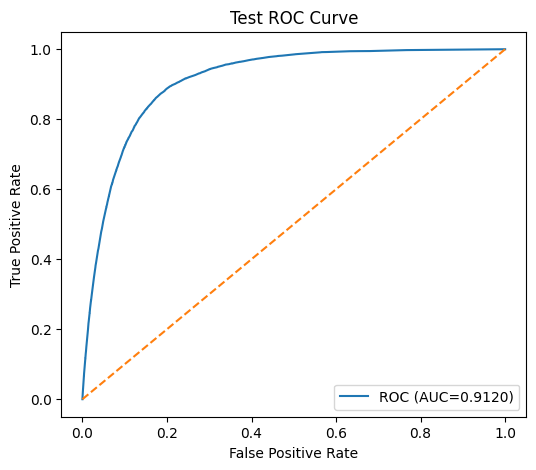

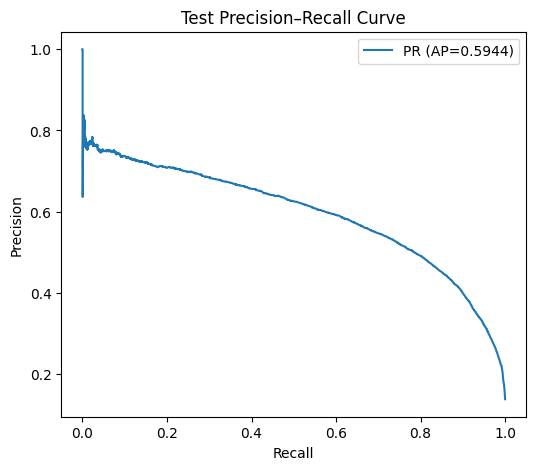

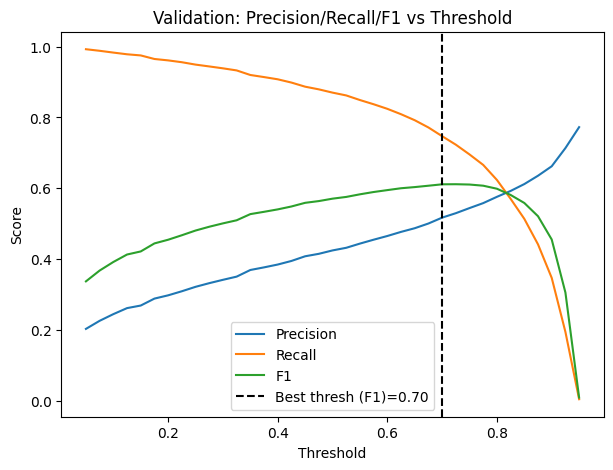

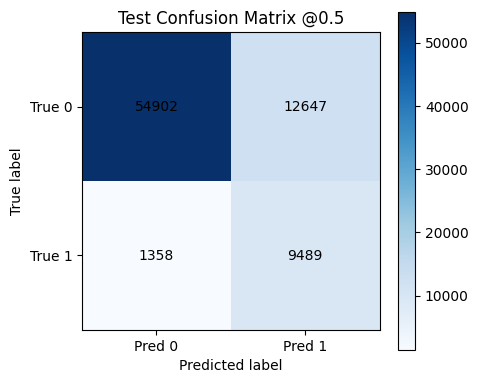

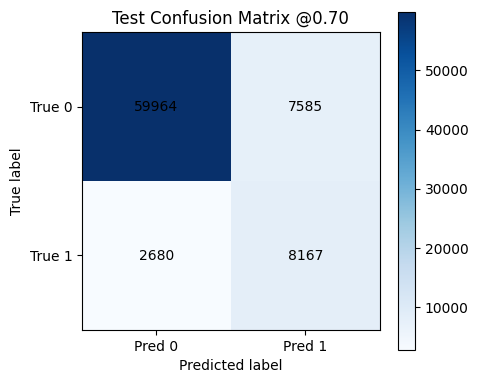

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
)
import numpy as np

# ============================
# 확률 추출 (LightGBM: best_iteration_ 반영)
# ============================
_best_iter = getattr(final_model, "best_iteration_", None)
if _best_iter is not None and _best_iter > 0:
    val_prob_best = final_model.predict_proba(X_val,  num_iteration=_best_iter)[:, 1]
    test_prob     = final_model.predict_proba(X_test, num_iteration=_best_iter)[:, 1]
else:
    val_prob_best = final_model.predict_proba(X_val)[:, 1]
    test_prob     = final_model.predict_proba(X_test)[:, 1]

# ---------------------------
# 1) ROC Curve (Test)
# ---------------------------
fpr, tpr, _ = roc_curve(y_test, test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC Curve")
plt.legend()
plt.show()

# ---------------------------
# 2) Precision–Recall Curve (Test)
# ---------------------------
prec, rec, _ = precision_recall_curve(y_test, test_prob)
pr_auc = average_precision_score(y_test, test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curve")
plt.legend()
plt.show()

# ---------------------------
# 3) Threshold vs Precision/Recall/F1 (Validation 기준)
# ---------------------------
def curve_threshold_metrics(y_true, y_prob, grid=np.linspace(0.05,0.95,37)):
    precs, recs, f1s = [], [], []
    for t in grid:
        y_pred = (y_prob >= t).astype(int)
        precs.append(precision_score(y_true, y_pred, zero_division=0))
        recs.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred))
    return grid, precs, recs, f1s

ts, precs, recs, f1s = curve_threshold_metrics(y_val, val_prob_best)

plt.figure(figsize=(7,5))
plt.plot(ts, precs, label="Precision")
plt.plot(ts, recs,  label="Recall")
plt.plot(ts, f1s,   label="F1")
plt.axvline(best_thresh, linestyle="--", color="k", label=f"Best thresh (F1)={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Validation: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.show()

# ---------------------------
# 4) Confusion Matrix (Test @0.5 vs @best_thresh)
# ---------------------------
def plot_cm(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.8,4.4))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], "d"),
                     ha="center", va="center", color="black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

plot_cm(y_test, test_prob, 0.5, "Test Confusion Matrix @0.5")
plot_cm(y_test, test_prob, best_thresh, f"Test Confusion Matrix @{best_thresh:.2f}")


In [29]:
# === Resampling at fixed threshold = 0.5 (LightGBM with best_params) ===
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix, accuracy_score
)
import lightgbm as lgb

# 1) y를 0/1로 (1=사망, 0=생존)
y_train_bin = (y_train == 1).astype(int)
y_val_bin   = (y_val   == 1).astype(int)
y_test_bin  = (y_test  == 1).astype(int)

# 2) 트리 모델은 스케일링 불필요 → 그대로 통과
preproc = ColumnTransformer(transformers=[], remainder="passthrough")

# 3) 튜닝된 best_params 반영
best_params = {
    "colsample_bytree": 0.8,
    "min_child_samples": 100,
    "num_leaves": 31,
    "reg_lambda": 1.0,
    "subsample": 0.8,
}

# 4) 기본 학습 세팅(객체 목적/메트릭/러닝레이트 등) + best_params 병합
base_lgbm_kwargs = dict(
    objective="binary",
    metric="auc",
    n_estimators=2000,       # early stopping으로 실제 best_iter에서 멈춤
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1,
    is_unbalance=False       # 리샘플링을 쓰므로 불균형 옵션은 끔
)
base_lgbm_kwargs.update(best_params)

def make_pipe_lgbm(sampler=None, random_state=42):
    clf = lgb.LGBMClassifier(**{**base_lgbm_kwargs, "random_state": random_state})
    steps = [("prep", preproc)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("clf", clf))
    return ImbPipeline(steps=steps)

pipelines = {
    "UnderSampler(RUS)+LGBM": make_pipe_lgbm(RandomUnderSampler(random_state=42)),
    "OverSampler(ROS)+LGBM":  make_pipe_lgbm(RandomOverSampler(random_state=42)),
}

def evaluate_fixed_thr(y_true, prob, thr=0.5):
    pred = (prob >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
    acc = accuracy_score(y_true, pred)
    roc = roc_auc_score(y_true, prob)
    prc = average_precision_score(y_true, prob)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {"ACC":acc, "F1":f1, "Precision":p, "Recall":r, "ROC-AUC":roc, "PR-AUC":prc,
            "TN":tn, "FP":fp, "FN":fn, "TP":tp}

rows = []
for name, pipe in pipelines.items():
    print(f"\n=== {name} @thr=0.50 ===")
    # 파이프라인의 최종 스텝(clf)에 fit 파라미터 전달: early stopping, eval set
    pipe.fit(
        X_train, y_train_bin,
        clf__eval_set=[(X_val, y_val_bin)],
        clf__eval_metric=["auc", "binary_logloss"],
        clf__callbacks=[
        lgb.early_stopping(100),     # ← 조기종료(개선 없으면 100라운드 후 stop)
        lgb.log_evaluation(50)       # ← 50라운드마다 로그(원하면 False로 없앨 수 있음)
        ]
    )

    # best_iteration_이 내부적으로 반영된 상태로 예측됨
    val_prob  = pipe.predict_proba(X_val)[:, 1]
    test_prob = pipe.predict_proba(X_test)[:, 1]

    val_res  = evaluate_fixed_thr(y_val_bin,  val_prob,  thr=0.5)
    test_res = evaluate_fixed_thr(y_test_bin, test_prob, thr=0.5)

    print(f"VAL  — F1:{val_res['F1']:.4f}  Rec:{val_res['Recall']:.4f}  "
          f"Prec:{val_res['Precision']:.4f}  AUC:{val_res['ROC-AUC']:.4f}  PR-AUC:{val_res['PR-AUC']:.4f}")
    print(f"TEST — F1:{test_res['F1']:.4f}  Rec:{test_res['Recall']:.4f}  "
          f"Prec:{test_res['Precision']:.4f}  AUC:{test_res['ROC-AUC']:.4f}  PR-AUC:{test_res['PR-AUC']:.4f}")
    print("TEST CM [[TN FP],[FN TP]]:", test_res["TN"], test_res["FP"], test_res["FN"], test_res["TP"])

    rows.append({"Model":name, **{k:(round(v,4) if isinstance(v,float) else v) for k,v in test_res.items()}})

result_05 = pd.DataFrame(rows).sort_values(by="F1", ascending=False)
print("\n=== Resampling (thr=0.50) — TEST summary (LGBM with best_params) ===")
print(result_05.to_string(index=False))



=== UnderSampler(RUS)+LGBM @thr=0.50 ===
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.398327	valid_0's auc: 0.907948
[100]	valid_0's binary_logloss: 0.391582	valid_0's auc: 0.908512
[150]	valid_0's binary_logloss: 0.3917	valid_0's auc: 0.908514
[200]	valid_0's binary_logloss: 0.392178	valid_0's auc: 0.908311
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.391494	valid_0's auc: 0.908539
VAL  — F1:0.5708  Rec:0.8679  Prec:0.4252  AUC:0.9085  PR-AUC:0.5821
TEST — F1:0.5753  Rec:0.8739  Prec:0.4288  AUC:0.9117  PR-AUC:0.5931
TEST CM [[TN FP],[FN TP]]: 54921 12628 1368 9479

=== OverSampler(ROS)+LGBM @thr=0.50 ===
Training until validation scores don't improve for 100 rounds
[50]	valid_0's binary_logloss: 0.398103	valid_0's auc: 0.908103
[100]	valid_0's binary_logloss: 0.390671	valid_0's auc: 0.908718
[150]	valid_0's binary_logloss: 0.389877	valid_0's auc: 0.90884
[200]	valid_0's binary_logloss: 0.389474	valid_0's auc: 